Antes de mais nada os notebooks aqui mostrado tiveram como base/foram retirados dos seguintes repositórios: 
 > https://github.com/fchollet/deep-learning-with-python-notebooks 
 
 
 > https://github.com/cdfmlr/Deep-Learning-with-Python-Notebooks
 
 Sugiro fortemente que consultem os códigos originais e em caso de dúvida podem me contatar para conversarmos. 

# Aprendizado profundo com Python

## 8.2 DeepDream

> DeepDream

DeepDream é uma tecnologia que permite que as máquinas modifiquem imagens. Ela usa redes neurais convolucionais para criar imagens muito psicodélicas:

Como a CNN usada pelo DeepDream é treinada no ImageNet, e há um grande número de fotos de animais no ImageNet, as imagens geradas pelo DeepDream contêm muitos animais e alguns artefatos de animais.

O algoritmo que o DeepDream usa é muito semelhante à tecnologia de visualização de filtros convolucionais de rede neural. Lembre-se de que a operação de visualização do filtro da rede neural convolucional é executar a rede neural convolucional ao contrário, inserir a partir de uma imagem em branco com ruído aleatório e fazer um aumento de gradiente para maximizar a ativação de um determinado filtro.

As principais diferenças entre DeepDream e visualização de filtro são:

-No DeepDream, tentamos maximizar a ativação de todas as camadas, não apenas uma camada, para que haja um grande número de recursos visuais misturados para gerar uma imagem mais psicodélica.
-Comece a partir de uma imagem existente, em vez da entrada de ruído aleatório, de modo que a imagem gerada contenha os padrões visuais existentes na imagem de entrada e alguns dos elementos sejam distorcidos, gerando uma aparência mais psicodélica imagem.
-A imagem de entrada será processada em escalas diferentes - essas escalas são chamadas de "oitava" (oitava), o que pode melhorar a qualidade da saída.

### Implementar DeepDream com Keras

Primeiro, precisamos selecionar uma rede neural convolucional pré-treinada no ImageNet: VGG16, Inception, ResNet50, etc. estão todos disponíveis. A prática provou que o Inception pode gerar melhor, então aqui usamos o modelo integrado do Inception V3 de Keras.

In [2]:
# Não use o modo de execução just-in-time

import tensorflow as tf

tf.compat.v1.disable_eager_execution()  # See https://github.com/tensorflow/tensorflow/issues/33135

In [3]:
# Carregue o modelo pré-treinado do Inception V3

from tensorflow.keras.applications import inception_v3
from tensorflow.keras import backend as K

K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Em seguida, defina a perda - a quantidade que precisa ser maximizada com o aumento do gradiente. No DeepDream, queremos maximizar a ativação de todos os filtros em várias camadas ao mesmo tempo. A implementação específica é realizar uma soma ponderada da norma L2 ativada por um grupo de camadas próximo ao topo, e então encontrar a maximização deste valor. A escolha das camadas e a distribuição do peso têm grande influência nos resultados gerados:

-Camadas próximas à parte inferior irão gerar padrões geométricos básicos;
-As camadas próximas ao topo irão gerar imagens que podem ver certos itens (padrões no ImageNet, como pássaros ou cachorros)

Basta escolher alguns aqui:

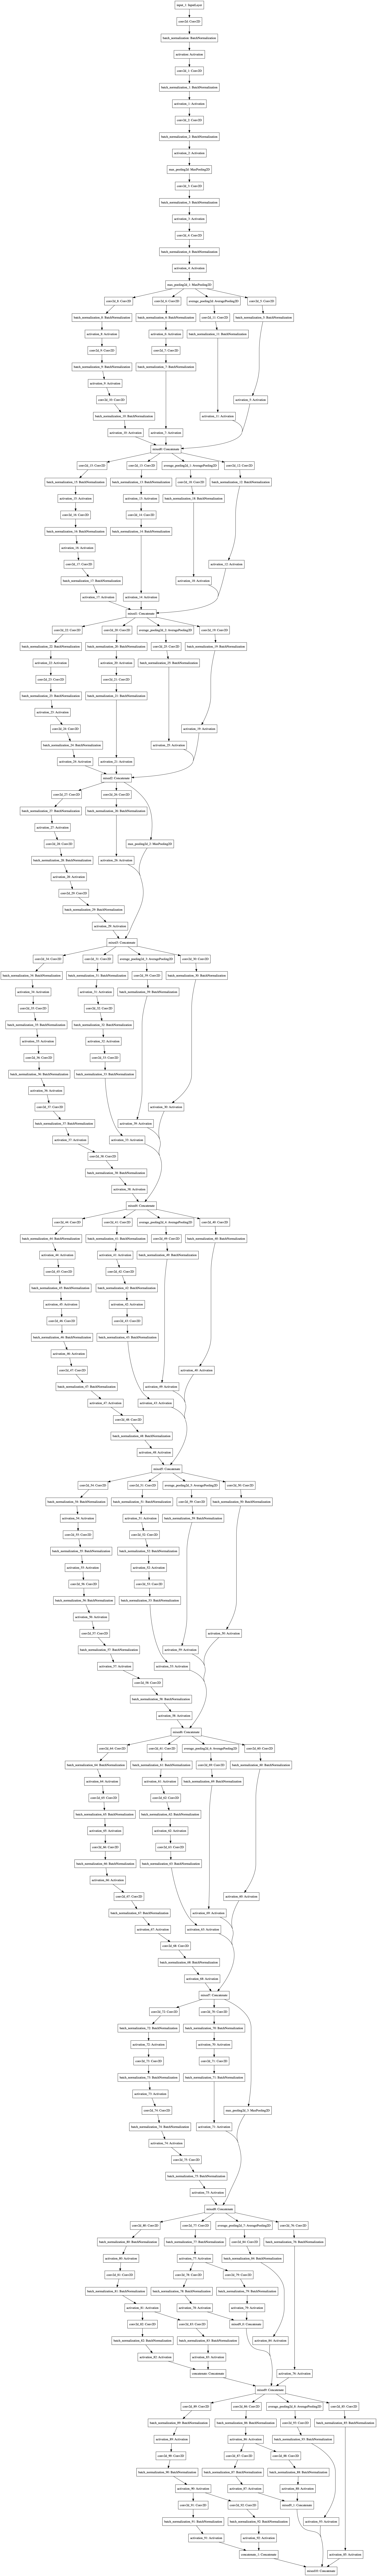

In [4]:
# Gerar a estrutura do modelo Inception V3 e selecionar a camada nele

import tensorflow as tf

tf.keras.utils.plot_model(model)

In [208]:
# DeepDream Configuração

layer_contributions = {
    'mixed4': 0.0,
    'mixed5': 3.0,
    'mixed6': 2.0,
    'mixed7': 1.5,
}

Encontre a perda para essas camadas selecionadas:

In [209]:
# Defina a perda a ser maximizada

layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = K.variable(0.)

for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    # loss += coeff * K.sum(K.square(activation[:, 2: -2, :])) / scaling
    # O código a seguir deve ser usado 👇. referência:https://github.com/fchollet/deep-learning-with-python-notebooks/issues/43
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, :])) / scaling

Subida gradiente de perda:

In [210]:
# Processo de subida gradiente

dream = model.input

grads = K.gradients(loss, dream)[0]

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print(f'   loss value at {i}: {loss_value}')
        x += step * grad_values
    return x

Finalmente, implemente o algoritmo DeepDream: primeiro defina uma lista de escalas (também chamadas de oitavas), que contém a imagem a ser processada. A imagem desta última escala é ampliada por um certo múltiplo que a anterior. O DeepDream seguirá essa lista do menor para o maior, fará a subida do gradiente na escala atual e, a seguir, ampliará a imagem resultante. Depois de aumentar o zoom, a imagem ficará borrada, então os detalhes que faltam devem ser reinjetados na imagem.
! [Processo DeepDream: ampliação contínua da escala de processamento espacial (oitava) e reinjeção de detalhes durante a ampliação](https://tva1.sinaimg.cn/large/007S8ZIlgy1ghrruc28b5j31o40u0nly.jpg)

In [211]:
# Função auxiliar

import scipy
import imageio

from tensorflow.keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1, 
               float(size[0]) / img.shape[1], 
               float(size[1]) / img.shape[2], 
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    # scipy.misc.imsave(fname, pil_img)
    imageio.imsave(fname, pil_img)
    
def preprocess_image(image_path):
    '''
    Usado para abrir a imagem, alterar o tamanho da imagem e converter o formato da imagem em um tensor que o modelo Inception V3 pode manipular
    '''
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    '''
    Converta um tensor em uma imagem válida
    '''
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
        
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [219]:
# Execute a subida do gradiente em várias escalas contínuas

import numpy as np

step = 0.01     # Tamanho do passo
num_octave = 3  # Número de escalas
octave_scale = 1.4 # Razão de duas escalas
iterations = 20 # Número de etapas para executar a subida do gradiente em cada escala

max_loss = 10.  # Pare o aumento do gradiente quando a perda aumentar muito para evitar artefatos feios

base_image_path = './img.png'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([dim // (octave_scale ** i)
                  for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname=f'dream_at_scale_{shape}.png')
    
save_img(img, fname='final_dream.png')

Processing image shape (510.0, 510.0)
   loss value at 0: 0.7559041976928711
   loss value at 1: 0.8942177295684814
   loss value at 2: 1.1383033990859985
   loss value at 3: 1.4416066408157349
   loss value at 4: 1.7937815189361572
   loss value at 5: 2.1449270248413086
   loss value at 6: 2.532114028930664
   loss value at 7: 2.892617702484131
   loss value at 8: 3.290109157562256
   loss value at 9: 3.6710917949676514
   loss value at 10: 4.045872211456299
   loss value at 11: 4.434374809265137
   loss value at 12: 4.7927985191345215
   loss value at 13: 5.176337718963623
   loss value at 14: 5.556784629821777
   loss value at 15: 5.9063920974731445
   loss value at 16: 6.234781742095947
   loss value at 17: 6.587921142578125
   loss value at 18: 6.890047073364258
   loss value at 19: 7.1789984703063965
Processing image shape (714.0, 714.0)
   loss value at 0: 1.6531521081924438
   loss value at 1: 2.5666146278381348
   loss value at 2: 3.2361338138580322
   loss value at 3: 3.76566

resultado:

! [Resultados do DeepDream] (https://tva1.sinaimg.cn/large/007S8ZIlgy1ghso9lpohzj31aq0li7wi.jpg)

Você pode ver que o DeepDream desenhou alguns cachorros na imagem final_dream 🐶.

Observação: devido ao tamanho de treinamento original do Inception V3, a implementação DeepDream implementada aqui pode obter melhores resultados em imagens com um tamanho entre 300 × 300 e 400 × 400, mas este não é um limite estrito, qualquer tamanho Tudo é possível.